# Customer Segmentation Project
This project aims to segment customers based on their demographic and transaction data using KMeans clustering. The goal is to identify distinct customer groups to better understand their characteristics and tailor marketing strategies accordingly.

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Load the dataset
file_path = 'customer_segmentation.csv'
data = pd.read_csv(file_path)

data.head()

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


The dataset contains the following columns:
- `customer_id`: Unique identifier for each customer
- `age`: Age of the customer
- `gender`: Gender of the customer
- `dependent_count`: Number of dependents the customer has
- `education_level`: Educational background of the customer
- `marital_status`: Marital status of the customer
- `estimated_income`: Estimated yearly income of the customer
- `months_on_book`: time as a customer in months
- `total_relationship_count`: number of times the customer was in touch with the company
- `months_inactive_12_mon`: Number of months the customer has been inactive in the last 12 months
- `credit_limit`: Credit limit of the customer
- `total_trans_amount`: Total transaction amount
- `total_trans_count`: Total number of transactions
- `avg_utilization_ratio`: Average utilization ratio of the credit limit
- `cluster`: Cluster assignment of the customer (output of the project)

## Data pre-processing

In [2]:
# Separate features and customer_id
customer_id = data['customer_id']
features = data.drop(columns=['customer_id'])

# Define categorical and numerical columns
categorical_columns = ['gender', 'education_level', 'marital_status']
numerical_columns = features.drop(columns=categorical_columns).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ])

# Apply preprocessing
processed_data = preprocessor.fit_transform(features)
processed_data_df = pd.DataFrame(processed_data, columns=numerical_columns.tolist() + preprocessor.named_transformers_['cat'].get_feature_names_out().tolist())

# Display the processed data
processed_data_df.head()

,age,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio,...,education_level_College,education_level_Doctorate,education_level_Graduate,education_level_High School,education_level_Post-Graduate,education_level_Uneducated,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Unknown
0,-0.165406,0.503368,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.333570,2.043199,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.583058,0.503368,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.789126,1.273283,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.789126,0.503368,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Determine the Optimal Number of Clusters
We will use the Elbow Method to find the optimal number of clusters for KMeans clustering.

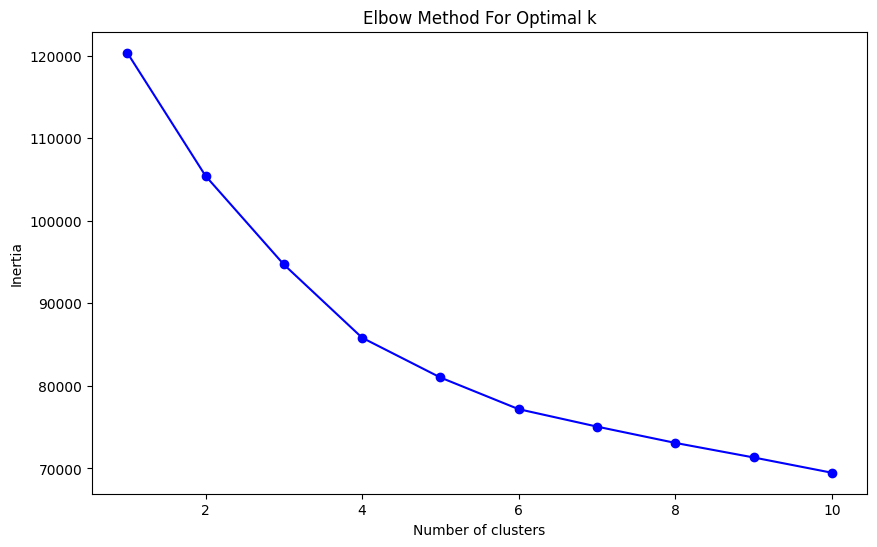

In [34]:
def plot_inertia_curve(data, max_clusters=10):
    inertia = []
    K = range(1, max_clusters + 1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(K, inertia, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

# Plot the inertia curve
plot_inertia_curve(processed_data_df)

## Clustering algorithm

In [35]:
# Define the number of clusters
n_clusters = 6

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(processed_data)

# Add the cluster labels to the original data
data['cluster'] = clusters + 1

## Clustering visualization

In [41]:
# Find the most important features by analyzing the cluster centers
importances = np.std(kmeans.cluster_centers_, axis=0)
feature_names = numerical_columns.tolist() + preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()
important_features = sorted(zip(importances, feature_names), reverse=True)

# Create a DataFrame of important features
important_features_df = pd.DataFrame(important_features, columns=['Importance', 'Feature'])

# Save the important features to a CSV file
important_features_df.to_csv('important_features.csv', index=False)

# Display the important features
important_features_df.head(10)

,Importance,Feature
0,1.046720,total_trans_amount
1,0.770709,age
2,0.758284,credit_limit
3,0.751114,total_trans_count
4,0.710569,months_on_book
5,0.696714,avg_utilization_ratio
6,0.654696,estimated_income
7,0.563738,dependent_count
8,0.468067,total_relationship_count
9,0.239286,gender_M


In [42]:
top_3_features = [feature for _, feature in important_features[:3]]

In [44]:
top_3_features

['total_trans_amount', 'age', 'credit_limit']

In [63]:
# Extract data for the top 3 features
top_3_data = data[top_3_features + ['cluster']].copy()
top_3_data['cluster'] = top_3_data['cluster'].astype('category')
top_3_data.sort_values('cluster', inplace=True)

# Create a 3D scatter plot
fig = px.scatter_3d(
    top_3_data,
    x=top_3_features[0],
    y=top_3_features[1],
    z=top_3_features[2],
    color='cluster',
    title='Top 3 Discriminating Features',
    width=1200,
    height=800,
)
fig.update_traces(marker=dict(size=3))

fig.show()

## Clustering features

In [20]:
# Computing cluster means

numerical_data = data.select_dtypes(include=['number'])
cluster_means = numerical_data.groupby('cluster').mean().reset_index()
cluster_means['cluster'] = cluster_means['cluster'].astype('category')
cluster_means.drop('customer_id', axis=1, inplace=True)

In [21]:
cluster_means

,cluster,age,dependent_count,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,1,35.420548,1.534932,55118.493151,25.743151,4.358904,2.141096,5460.454726,3029.978082,56.755479,0.311794
1,2,46.280702,2.880201,41396.491228,35.714787,3.777444,2.375439,2641.169925,4100.905764,69.812531,0.642692
2,3,47.086629,2.588826,119215.944758,36.631513,4.004394,2.340239,22511.374890,3394.576899,57.831136,0.069891
3,4,45.303295,2.325581,67549.418605,35.081395,2.147287,2.180233,14318.605620,12891.469961,105.217054,0.168630
4,5,56.735770,1.068904,52271.420012,45.328939,4.156381,2.453565,5129.222648,2994.185141,54.176153,0.312058
5,6,45.687553,3.139193,49934.398654,35.659798,3.859546,2.426829,6297.856770,3484.547519,60.368377,0.101039


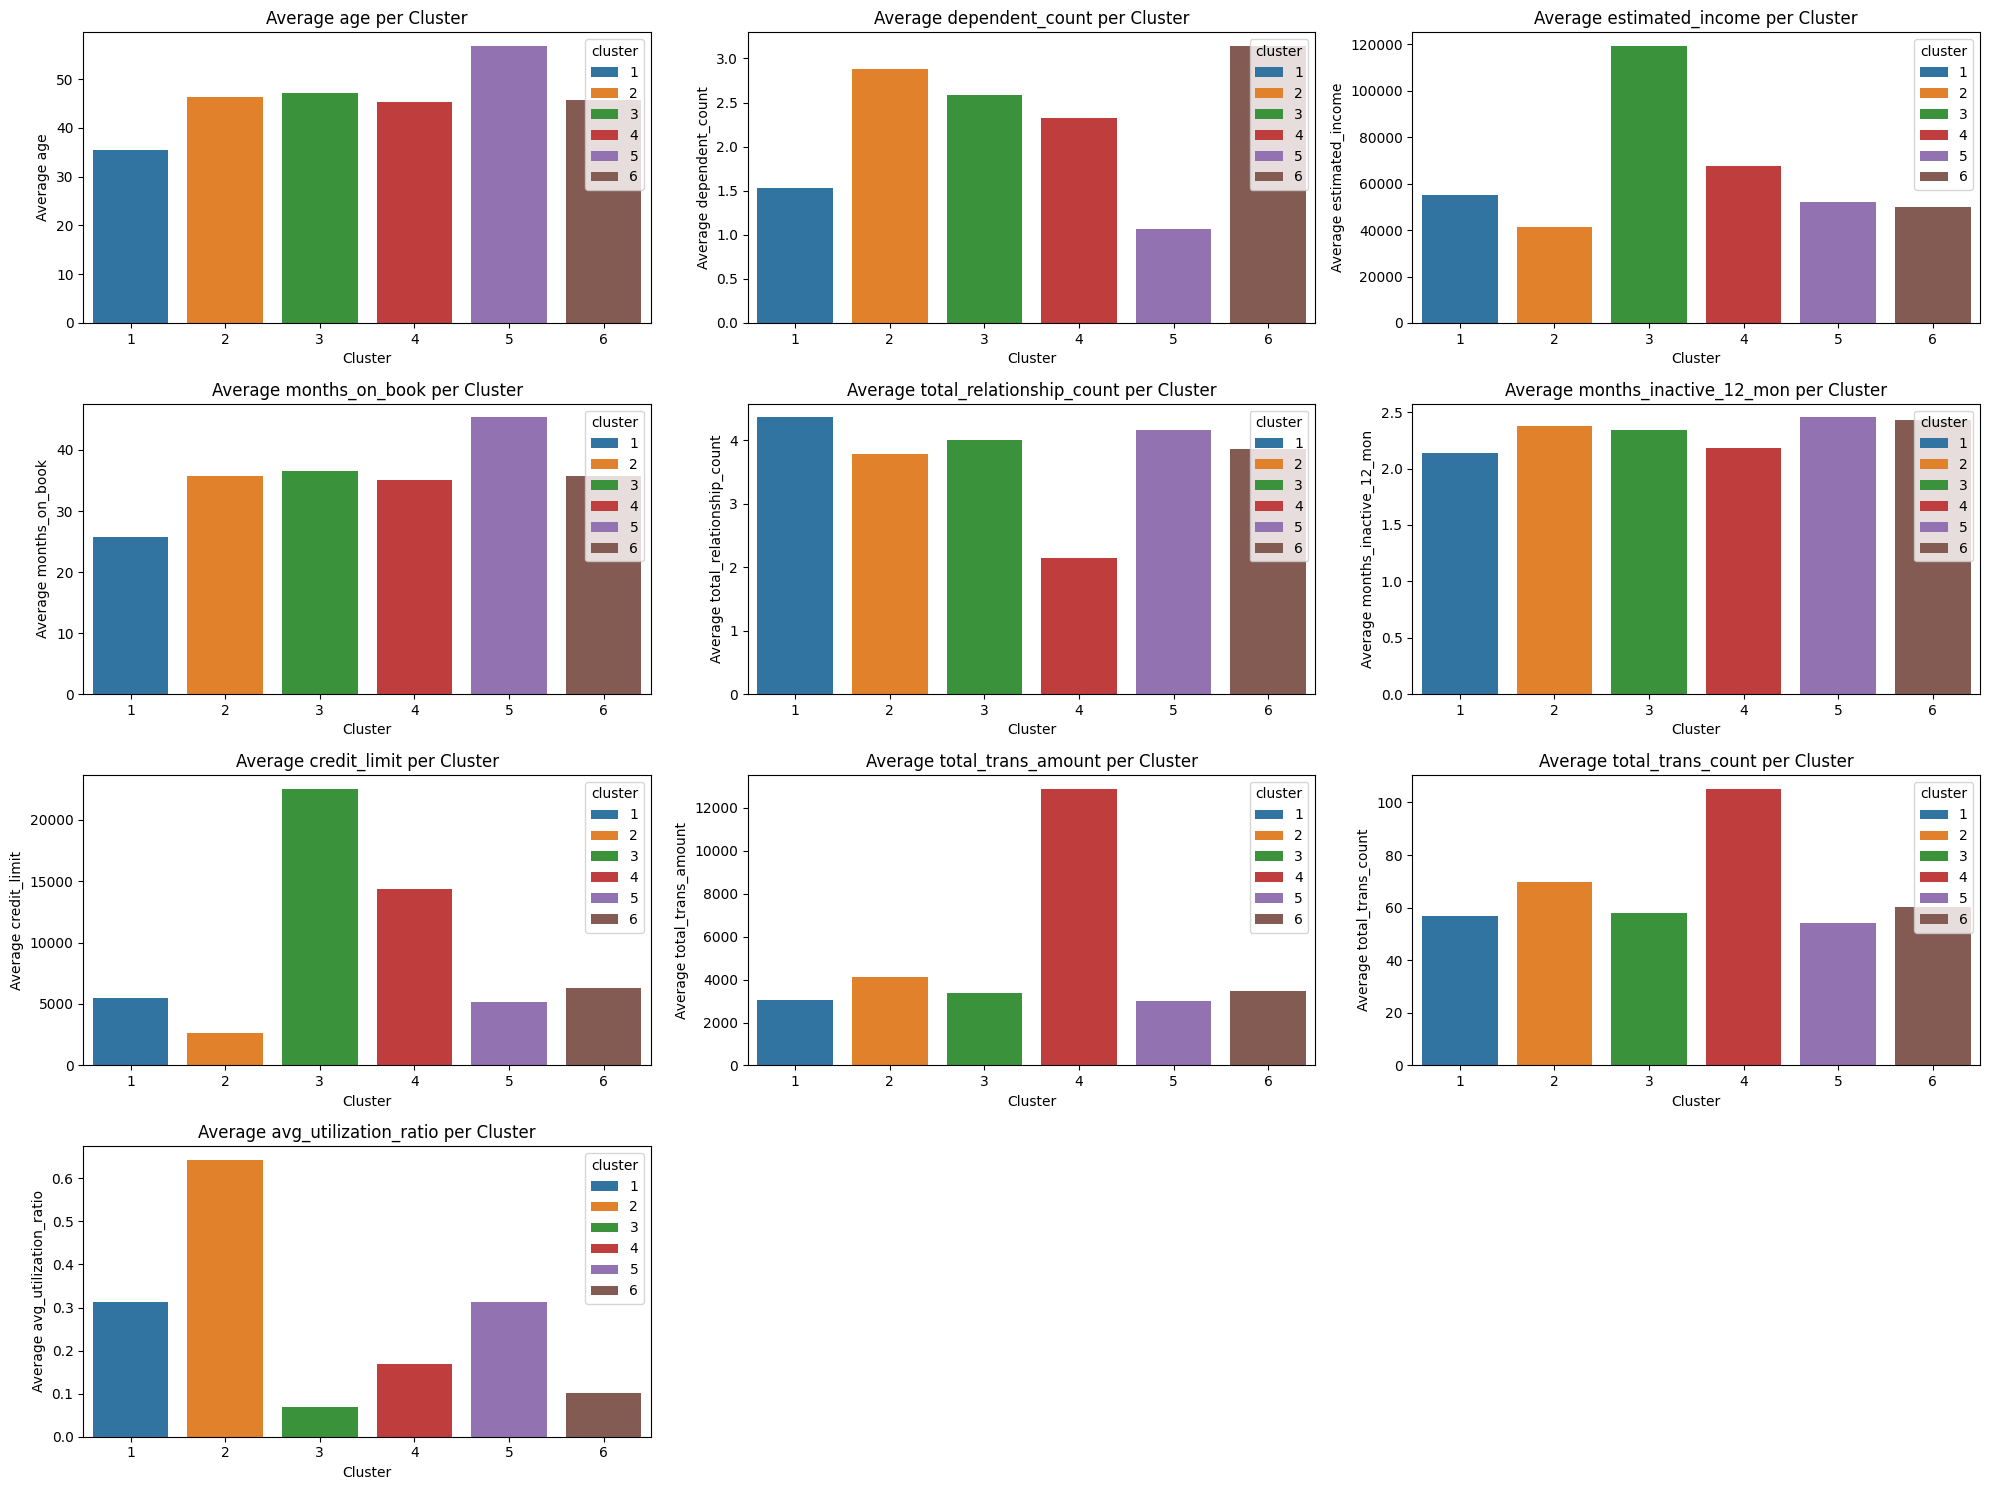

In [65]:
# Number of numerical features
num_columns = len(cluster_means.columns) - 1

# Plot mean per cluster for all numerical features
fig, axes = plt.subplots(4, 3, figsize=(20, 15))
axes = axes.flatten()

for idx, column in enumerate(cluster_means.columns[1:]):
    sns.barplot(x='cluster', y=column, data=cluster_means, hue='cluster', ax=axes[idx])
    axes[idx].set_title(f'Average {column} per Cluster')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(f'Average {column}')

for idx in range(num_columns, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [66]:
# Computing the Share of Voice of each occurence for categorical variables
categorical_columns = ['gender', 'education_level', 'marital_status']

sov_results = {}

for column in categorical_columns:
    sov_results[column] = data.groupby(['cluster', column]).size().unstack(fill_value=0).apply(lambda x: x / x.sum(), axis=1)

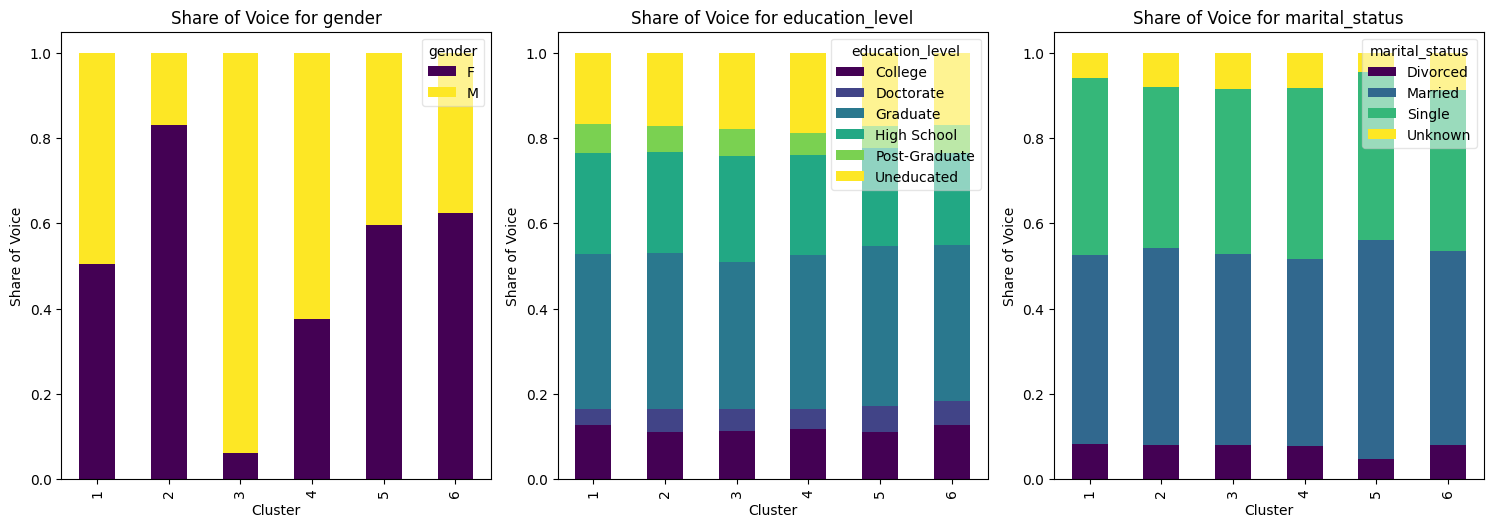

In [67]:
# Number of categorical features
num_columns = len(sov_results)

# Plot SoV of each occurence for each categorical feature
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for idx, (column, result) in enumerate(sov_results.items()):
    result.plot(kind='bar', stacked=True, colormap='viridis', ax=axes[idx])
    axes[idx].set_title(f'Share of Voice for {column}')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel('Share of Voice')
    legend = axes[idx].legend(title=column, loc='upper right', bbox_to_anchor=(1, 1))
    legend.get_frame().set_alpha(0.5)

for idx in range(num_columns, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


## Clustering interpretation

### 1. Young Professionals
   * **Age**: ~35 years
   * **Dependent Count**: ~1.5
   * **Estimated Income**: ~\$55,000
   * **Months on book**: ~26
   * **Credit Limit**: ~\$5,460
   * **Total Transactions**: ~57
   * **Utilization Ratio**: ~0.31
   * **Characteristics**: Relatively young with moderate income and credit limit, actively using credit.

### 2. Moderate Income Middle-Aged
   * **Age**: ~46 years
   * **Dependent Count**: ~2.9
   * **Estimated Income**: ~\$41,000
   * **Months on book**: ~36
   * **Credit Limit**: ~\$2,641
   * **Total Transactions**: ~70
   * **Utilization Ratio**: ~0.64
   * **Characteristics**: Middle-aged with moderate income, high utilization ratio, and moderate transaction activity.
   * **Mostly Female customers**

### 3. Wealthy Middle-Aged
   * **Age**: ~47 years
   * **Dependent Count**: ~2.6
   * **Estimated Income**: ~\$119,000
   * **Months on book**: ~37
   * **Credit Limit**: ~\$22,511
   * **Total Transactions**: ~58
   * **Utilization Ratio**: ~0.07
   * **Characteristics**: High income and credit limit, low utilization ratio, middle-aged with moderate transactions.
   * **Mostly Male customers**

### 4. High Spenders
   * **Age**: ~45 years
   * **Dependent Count**: ~2.3
   * **Estimated Income**: ~\$67,500
   * **Months on book**: ~35
   * **Credit Limit**: ~\$14,319
   * **Total Transactions**: ~105
   * **Utilization Ratio**: ~0.17
   * **Characteristics**: High transaction volume and credit limit, middle-aged, moderate utilization
   * **Slighlty more Male customers**

### 5. Senior Savers
   * **Age**: ~57 years
   * **Dependent Count**: ~1.1
   * **Estimated Income**: ~\$52,000
   * **Months on book**: ~45
   * **Credit Limit**: ~\$5,129
   * **Total Transactions**: ~54
   * **Utilization Ratio**: ~0.31
   * **Characteristics**: Older individuals with lower dependent count, moderate income, and savings behavior.

### 6. Family Focused
   * **Age**: ~45 years
   * **Dependent Count**: ~3.1
   * **Estimated Income**: ~\$49,000
   * **Months on book**: ~35
   * **Credit Limit**: ~\$6,298
   * **Total Transactions**: ~60
   * **Utilization Ratio**: ~0.10
   * **Characteristics**: Moderate income, larger families, moderate credit limit, and transaction volume.


## Applying Principal Component analysis to better vizualise clusters

In [81]:
# Apply PCA to reduce the dataset to 3 dimensions
pca = PCA(n_components=3)
pca_data = pca.fit_transform(processed_data)

# Create a DataFrame with the PCA results and cluster labels
pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2', 'PC3'])
pca_df['cluster'] = data['cluster'].astype('category')
pca_df.sort_values('cluster', inplace=True)


# Create a 3D scatter plot
fig = px.scatter_3d(
    pca_df, 
    x='PC1', 
    y='PC2', 
    z='PC3', 
    color='cluster',
    title='top 3 PCA features decomposition',
    width=1200,
    height=800,
)
fig.update_traces(marker=dict(size=3))

fig.show()

In [83]:
# Compute the "loadings", i.e. the coefficients of the linear combination of the original variables from which the principal components are constructed
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=numerical_columns.tolist() + preprocessor.named_transformers_['cat'].get_feature_names_out().tolist())

In [84]:
def plot_loadings(loadings, pcs, top_n=10):
    fig, axs = plt.subplots(3, 1, figsize=(10, 18))
    
    for i, pc in enumerate(pcs):
        sorted_loadings = loadings[pc].sort_values(key=abs, ascending=False).head(top_n)
        sns.barplot(ax=axs[i], x=sorted_loadings.values, y=sorted_loadings.index, hue=sorted_loadings.index, palette='viridis')
        axs[i].set_title(f'Top {top_n} Features Influencing {pc}')
        axs[i].set_xlabel('Loading Score')
        axs[i].set_ylabel('Feature')
    
    plt.tight_layout()
    plt.show()

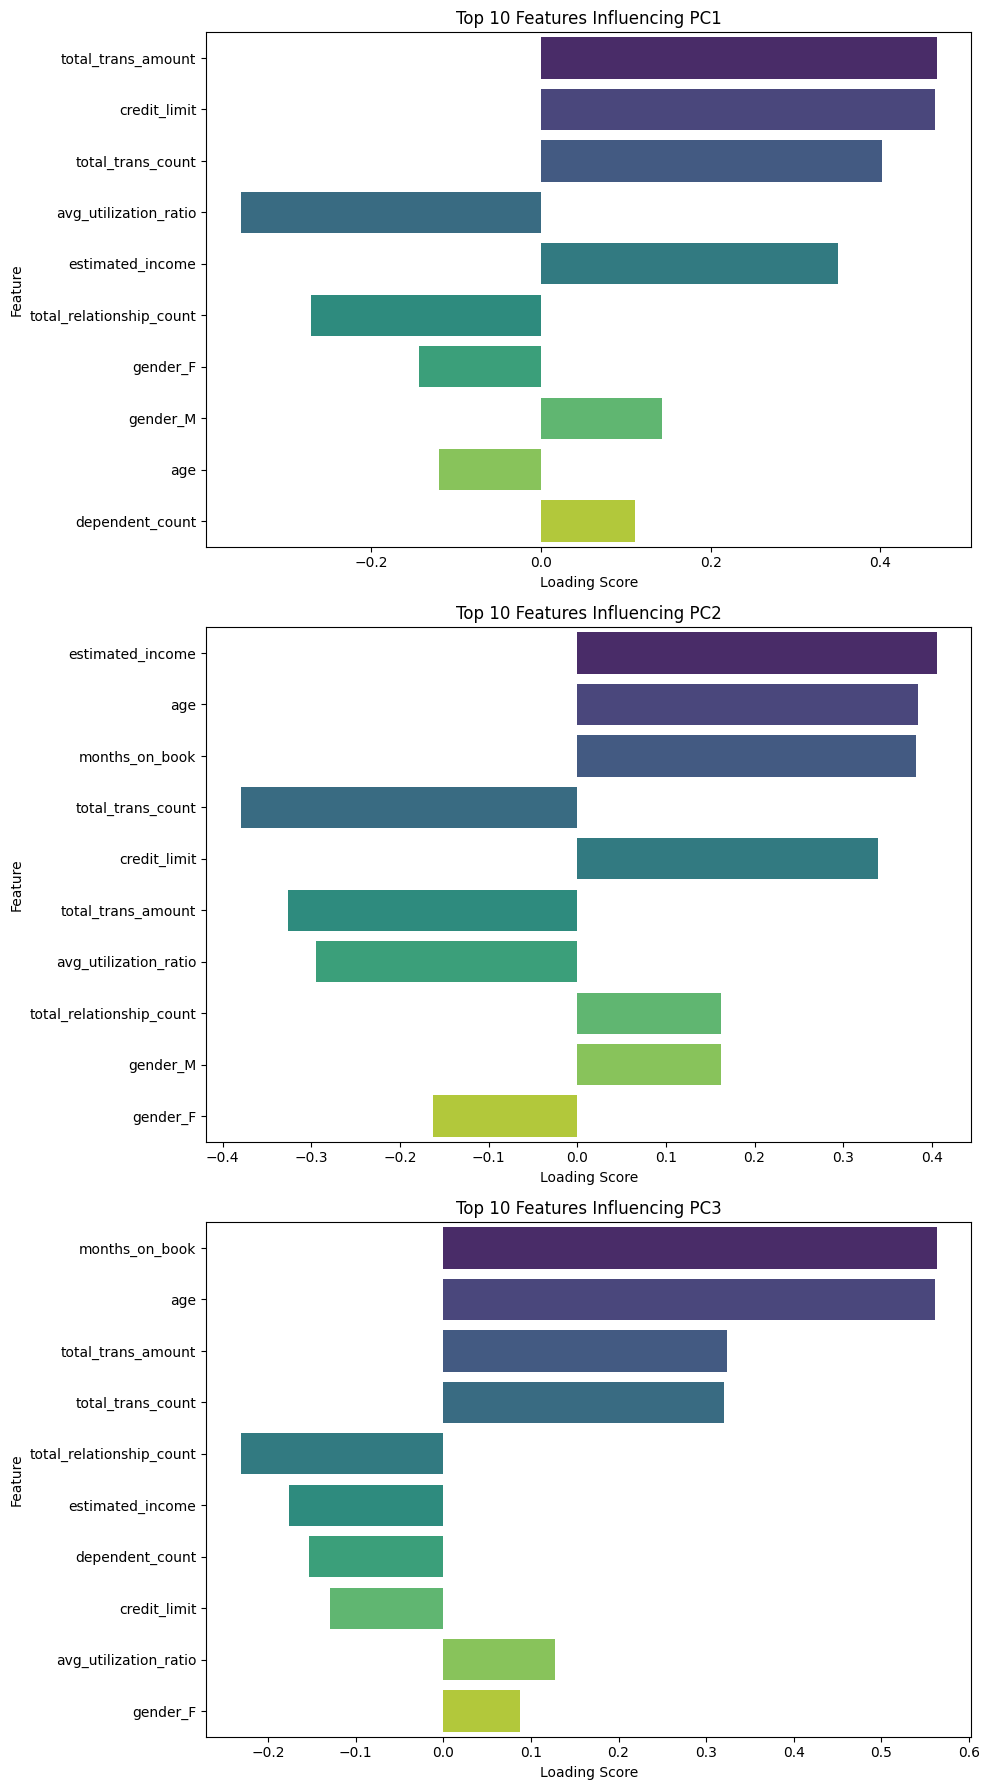

In [85]:
plot_loadings(loadings, ['PC1', 'PC2', 'PC3'])